In [ ]:
# !pip install qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms pylatexenc

In [ ]:
# !pip list | grep qiskit

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### **Quantum feature maps and kernels**

---

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


<br>

**1. import dataset**

---

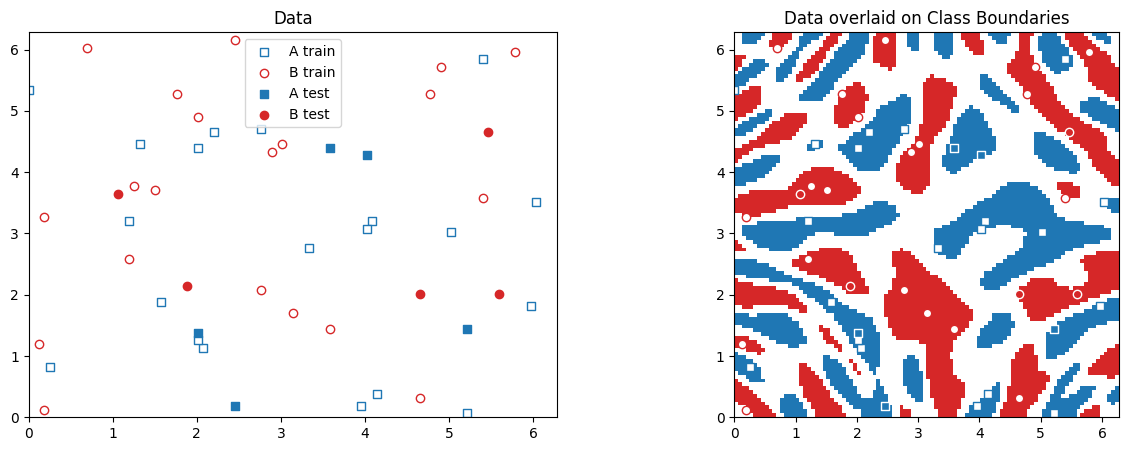

In [ ]:
from qiskit_machine_learning.datasets import ad_hoc_data

train_data, train_labels, test_data, test_labels, sample_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=2,
    gap=0.3,
    include_sample_total=True,
    plot_data=False,
    one_hot=False
)


# Plot data and class boundaries
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(121)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)
plt.scatter(
    train_data[np.where(train_labels[:] == 0), 0],
    train_data[np.where(train_labels[:] == 0), 1],
    marker='s', facecolors='w', edgecolors='C0', label="A train"
)
plt.scatter(
    train_data[np.where(train_labels[:] == 1), 0],
    train_data[np.where(train_labels[:] == 1), 1],
    marker='o', facecolors='w', edgecolors='C3', label="B train"
)
plt.scatter(
    test_data[np.where(test_labels[:] == 0), 0],
    test_data[np.where(test_labels[:] == 0), 1],
    marker='s', facecolors='C0', label="A test"
)
plt.scatter(
    test_data[np.where(test_labels[:] == 1), 0],
    test_data[np.where(test_labels[:] == 1), 1],
    marker='o', facecolors='C3', label="B test"
)
plt.legend()

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["C3","w","C0"])
axboth = fig.add_subplot(122)
axboth.set_title("Data overlaid on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(
    np.asmatrix(sample_total).T,
    interpolation='nearest', origin='lower',
    cmap=cmap, extent=[0, 2 * np.pi, 0, 2 * np.pi]
)
axboth.scatter(
  train_data[np.where(train_labels[:] == 0), 0],
  train_data[np.where(train_labels[:] == 0), 1],
  marker='s', facecolors='w', edgecolors='C0', label="A"
)
axboth.scatter(
  train_data[np.where(train_labels[:] == 1), 0],
  train_data[np.where(train_labels[:] == 1), 1],
  marker='o', facecolors='w', edgecolors='C3', label="B"
)
axboth.scatter(
  test_data[np.where(test_labels[:] == 0), 0],
  test_data[np.where(test_labels[:] == 0), 1],
  marker='s', facecolors='C0', edgecolors='w', label="A test"
)
axboth.scatter(
  test_data[np.where(test_labels[:] == 1), 0],
  test_data[np.where(test_labels[:] == 1), 1],
  marker='o', facecolors='C3', edgecolors='w', label="B test"
)
plt.show()


<br>

**2. feature map**

---

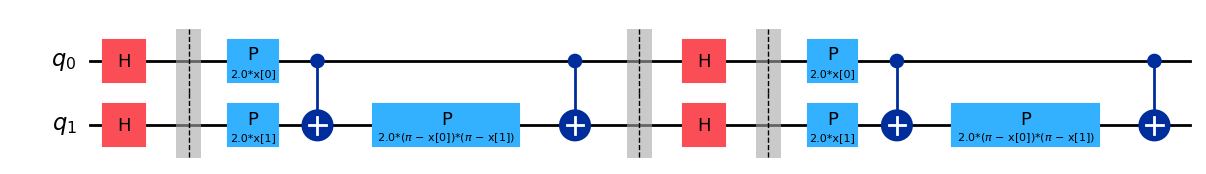

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

# define feature_map
adhoc_feature_map = ZZFeatureMap(
    feature_dimension=2,
    reps=2,
    insert_barriers=True
)

adhoc_feature_map.decompose().draw('mpl')


<br>

**3. Quantum kernel(Analytical)**

---

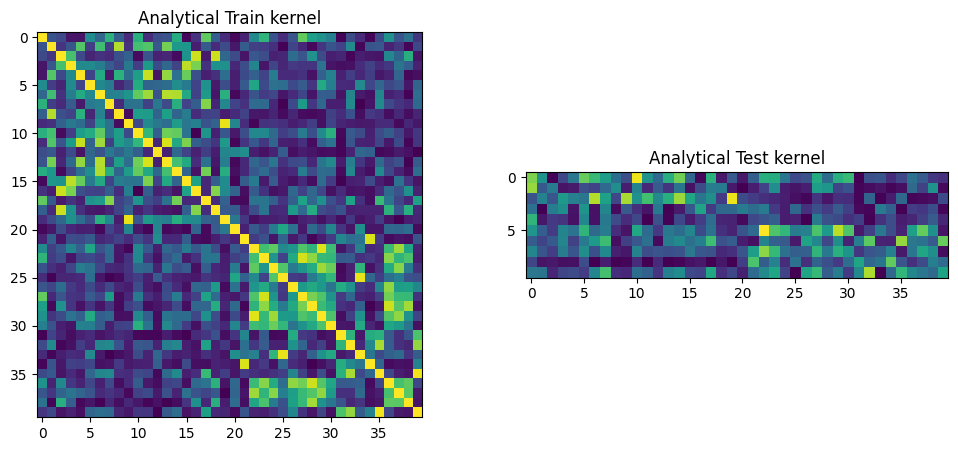

In [ ]:

from qiskit.quantum_info import Statevector

# Analytical function to calculate kernel matrix
# kernel entry : K(i,j) = |<y_j | x_i>|^2
def calculate_kernel(feature_map, x_data, y_data=None):
    if y_data is None:
      y_data = x_data

    x_vec = np.array([Statevector(feature_map.assign_parameters(x)).data for x in x_data])
    y_vec = np.array([Statevector(feature_map.assign_parameters(y)).data for y in y_data])

    inner_products = x_vec @ y_vec.conj().T
    kernel = np.abs(inner_products)**2
    return kernel

train_kernel = calculate_kernel(adhoc_feature_map, train_data)
test_kernel = calculate_kernel(adhoc_feature_map, test_data, train_data)


# plot kernel matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest', origin='upper')
axs[0].set_title('Analytical Train kernel')

axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest', origin='upper')
axs[1].set_title('Analytical Test kernel')

plt.show()


<br>

**4. Support Vector Classification**

---

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)
print("Number of support vectors for each class:",model.n_support_)
print("Indices of support vectors:", model.support_)

Number of support vectors for each class: [ 9 10]
Indices of support vectors: [ 0  2  4  5  7 12 13 17 18 20 21 22 27 28 29 30 32 35 39]


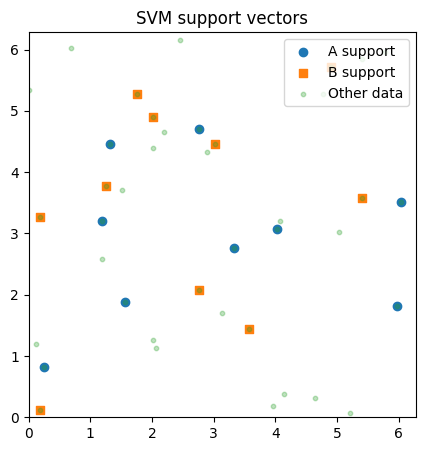

In [ ]:
support_indices_A = model.support_[:model.n_support_[0]]
support_indices_B = model.support_[model.n_support_[0]:]

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)

plt.scatter(
    train_data[support_indices_A, 0],
    train_data[support_indices_A, 1],
    marker='o',
    label='A support'
)

plt.scatter(
    train_data[support_indices_B, 0],
    train_data[support_indices_B, 1],
    marker='s',
    label='B support'
)

plt.scatter(train_data[:, 0], train_data[:, 1], alpha=0.3, s=10, label='Other data')
plt.title('SVM support vectors')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.score(test_kernel, test_labels)

1.0


<br>

**kernel from qiskit**

---

Number of support vectors for each class: [ 9 11]
Indices of support vectors: [ 0  2  4  5  7 12 13 17 18 20 21 22 23 27 28 29 30 32 35 39]
Test score: 1.0


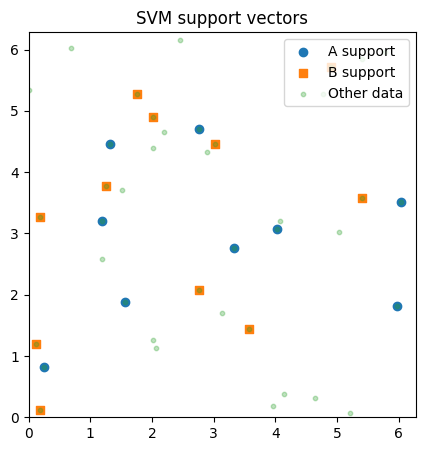

In [ ]:
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# 1. setup kernel
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler)
kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map, fidelity=fidelity)

# 2. train model SVC
model = SVC(kernel=kernel.evaluate)
model.fit(train_data, train_labels)
print("Number of support vectors for each class:",model.n_support_)
print("Indices of support vectors:", model.support_)

# 3. calculate score
score = model.score(test_data, test_labels)
print("Test score:", score)

# 4. plot support vectors
support_indices_A = model.support_[:model.n_support_[0]]
support_indices_B = model.support_[model.n_support_[0]:]

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)

plt.scatter(
    train_data[support_indices_A, 0],
    train_data[support_indices_A, 1],
    marker='o',
    label='A support'
)

plt.scatter(
    train_data[support_indices_B, 0],
    train_data[support_indices_B, 1],
    marker='s',
    label='B support'
)

plt.scatter(train_data[:, 0], train_data[:, 1], alpha=0.3, s=10, label='Other data')
plt.title('SVM support vectors')
plt.legend(loc='upper right')
plt.show()

Do the matrices match? False
Average element-wise difference: 0.0090331244


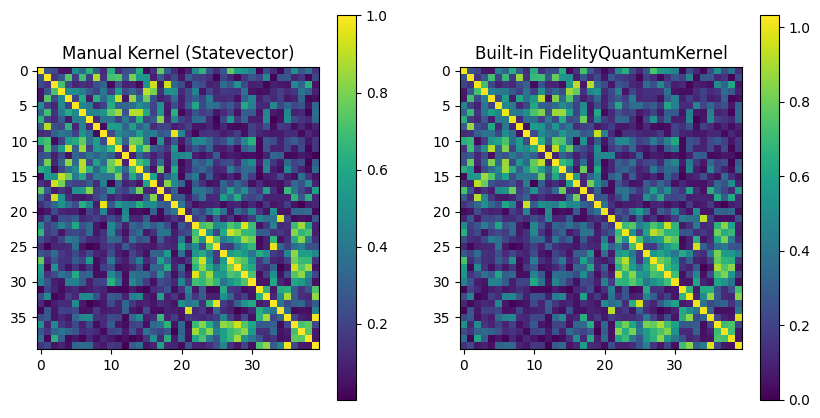

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute Manual Kernel
manual_kernel_matrix = calculate_kernel(adhoc_feature_map, train_data)

# 2. Compute Built-in Kernel
builtin_kernel_matrix = kernel.evaluate(x_vec=train_data)

# 3. Numerical Comparison
# checks if all elements are equal within a small tolerance (e.g. 1e-8)
matches = np.allclose(manual_kernel_matrix, builtin_kernel_matrix)
print(f"Do the matrices match? {matches}")

# Calculate average difference
diff = np.abs(manual_kernel_matrix - builtin_kernel_matrix).mean()
print(f"Average element-wise difference: {diff:.10f}")

# 4. Visual Comparison ---
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im1 = axs[0].imshow(manual_kernel_matrix, origin='upper', cmap='viridis')
axs[0].set_title("Manual Kernel (Statevector)")
fig.colorbar(im1, ax=axs[0])


im2 = axs[1].imshow(builtin_kernel_matrix, origin='upper', cmap='viridis')
axs[1].set_title("Built-in FidelityQuantumKernel")
fig.colorbar(im2, ax=axs[1])

plt.show()